In [1]:
import os
import pandas as pd

In [2]:
# === Step 1: Define directory paths ===
base_dir = "/Users/twylazhang/Desktop/Honor Thesis/occupation_Analysis"
input_dir = os.path.join(base_dir, "OEWS")
output_dir = os.path.join(base_dir, "output", "3_merge_OEWS")
output_path = os.path.join(output_dir, "1_merged_OEWS_2015_2023.xlsx")

# === Step 2: Ensure output directory exists ===
os.makedirs(output_dir, exist_ok=True)

# === Step 3: Prepare file list ===
file_list = [f"national_M{year}_dl.xlsx" for year in range(2015, 2025)]

# === Step 4: Harmonize column names across all years ===
def harmonize_columns(df):
    # Normalize all column names to lowercase
    df.columns = [col.strip().lower() for col in df.columns]

    # Harmonize column name variations
    rename_map = {
        "occ_group": "o_group",
        "occ_code": "occ_code",
        "occ_title": "occ_title",
        "tot_emp": "tot_emp",
        "emp_prse": "emp_prse",
        "h_mean": "h_mean",
        "a_mean": "a_mean",
        "mean_prse": "mean_prse",
        "h_median": "h_median",
        "a_median": "a_median",
        "h_pct10": "h_pct10",
        "h_pct25": "h_pct25",
        "h_pct75": "h_pct75",
        "h_pct90": "h_pct90",
        "a_pct10": "a_pct10",
        "a_pct25": "a_pct25",
        "a_pct75": "a_pct75",
        "a_pct90": "a_pct90",
        "annual": "annual",
        "hourly": "hourly",
        "area": "area",
        "area_title": "area_title",
        "area_type": "area_type",
        "prim_state": "prim_state",
        "naics": "naics",
        "naics_title": "naics_title",
        "i_group": "i_group",
        "own_code": "own_code",
        "jobs_1000": "jobs_1000",
        "loc_quotient": "loc_quotient",
        "pct_total": "pct_total",
        "pct_rpt": "pct_rpt"
    }

    # Apply renaming
    df = df.rename(columns=rename_map)

    # Ensure 'o_group' exists
    if "o_group" not in df.columns:
        df["o_group"] = None

    # Ensure occupation title is clean
    if "occ_title" in df.columns:
        df["occ_title"] = df["occ_title"].astype(str).str.strip().str.lower()

    return df

# === Step 5: Merge loop ===
df_list = []
all_columns = set()

for file in file_list:
    file_path = os.path.join(input_dir, file)

    try:
        xls = pd.ExcelFile(file_path)
    except FileNotFoundError:
        print(f"❌ File not found: {file_path}")
        continue

    sheet_names = xls.sheet_names
    year = int(file.split("M")[1][:4])
    sheet_name = "national_dl" if "national_dl" in sheet_names else f"national_M{year}_dl"
    if sheet_name not in sheet_names:
        print(f"⚠️ No valid sheet found in {file}. Skipping.")
        continue

    df = xls.parse(sheet_name)
    df = harmonize_columns(df)
    df["year"] = year

    all_columns.update(df.columns)
    df_list.append(df)

# === Step 6: Align columns and save output ===
if df_list:
    all_columns = sorted(all_columns)

    aligned_list = []
    for df in df_list:
        for col in all_columns:
            if col not in df.columns:
                df[col] = None
        aligned_list.append(df[all_columns])

    merged_df = pd.concat(aligned_list, ignore_index=True)
    merged_df.to_excel(output_path, index=False)
    print(f"✅ Merged file saved at: {output_path}")
else:
    print("❌ No valid files to merge.")

✅ Merged file saved at: /Users/twylazhang/Desktop/Honor Thesis/occupation_Analysis/output/3_merge_OEWS/1_merged_OEWS_2015_2023.xlsx


# Merge with automation score

In [3]:
import pandas as pd
import re
import os

# === Step 1: Load Datasets ===
oews_path = "output/3_merge_OEWS/1_merged_OEWS_2015_2023.xlsx"
automation_path = "ONET_Degree_of_Automation.xlsx"

df_oews = pd.read_excel(oews_path)
df_automation = pd.read_excel(automation_path)

# === Step 2: Improved Standardization Function ===
def safe_standardize_title(title):
    title = title.lower()
    title = re.sub(r'&', 'and', title)
    title = re.sub(r'[^a-z0-9\s]', '', title)          # remove punctuation
    title = re.sub(r'\bworkers\b', 'worker', title)    # unify singular/plural
    title = re.sub(r'\boccupations\b', 'occupation', title)
    title = re.sub(r'\bmanagers\b', 'manager', title)
    title = re.sub(r'\bsupervisors\b', 'supervisor', title)
    title = re.sub(r'\bspecialists\b', 'specialist', title)
    title = re.sub(r'\stechnicians\b', 'technician', title)
    title = title.replace("all other", "")
    title = title.replace("not elsewhere classified", "")
    title = re.sub(r'\s+', ' ', title).strip()          # clean extra spaces
    return title

# === Step 3: Normalize and Standardize Columns ===
df_oews.rename(columns=lambda x: x.strip().lower(), inplace=True)
df_automation.rename(columns=lambda x: x.strip().lower(), inplace=True)

if 'occ_title' not in df_oews.columns:
    raise KeyError("❌ 'occ_title' not found in OEWS data.")
if 'occupation' not in df_automation.columns:
    raise KeyError("❌ 'occupation' not found in automation data.")

df_oews['safe_std_title'] = df_oews['occ_title'].astype(str).apply(safe_standardize_title)
df_automation['safe_std_occupation'] = df_automation['occupation'].astype(str).apply(safe_standardize_title)

# === Step 4: Outer Merge — Keep All Rows ===
merged_df = pd.merge(
    df_oews,
    df_automation,
    left_on='safe_std_title',
    right_on='safe_std_occupation',
    how='outer',
    indicator=True
)

# === Step 5: Summary
print(f"✅ Total merged rows: {len(merged_df)}")
print(f"✔️ Matched: {len(merged_df[merged_df['_merge'] == 'both'])}")
print(f"❗ Unmatched OEWS: {len(merged_df[merged_df['_merge'] == 'left_only'])}")
print(f"❗ Unmatched ONET: {len(merged_df[merged_df['_merge'] == 'right_only'])}")

# === Step 6: Save Output
output_path = os.path.join(os.path.dirname(oews_path), "2_matched_OEWS_with_Automation_by_Title.xlsx")
merged_df.to_excel(output_path, index=False)
print(f"✅ Merged file saved at: {output_path}")

✅ Total merged rows: 13962
✔️ Matched: 9244
❗ Unmatched OEWS: 4574
❗ Unmatched ONET: 144
✅ Merged file saved at: output/3_merge_OEWS/2_matched_OEWS_with_Automation_by_Title.xlsx


# clean and prepare for regresison

In [4]:
import pandas as pd
import numpy as np
import os

# === Step 1: Load the merged dataset ===
file_path = "output/3_merge_OEWS/2_matched_OEWS_with_Automation_by_Title.xlsx"
df = pd.read_excel(file_path)

# === Step 2: Normalize column names ===
df.columns = df.columns.str.strip().str.lower()

# === Step 3: Keep only matched rows ===
df = df[df["_merge"] == "both"].copy()

# === Step 4: Rename 'context' to 'automation_score' if needed ===
if "context" in df.columns:
    df.rename(columns={"context": "automation_score"}, inplace=True)

# === Step 5: Drop rows missing required regression variables ===
required_columns = ["a_mean", "automation_score", "job zone"]
df_cleaned = df.dropna(subset=required_columns).copy()

# === Step 6: Convert to numeric where needed ===
df_cleaned["automation_score"] = pd.to_numeric(df_cleaned["automation_score"], errors="coerce")
df_cleaned["a_mean"] = pd.to_numeric(df_cleaned["a_mean"], errors="coerce")
df_cleaned["job zone"] = pd.to_numeric(df_cleaned["job zone"], errors="coerce")

# === Step 7: Save full cleaned dataset ===
base_dir = os.path.dirname(file_path)
all_path = os.path.join(base_dir, "3_all_cleaned_for_regression.xlsx")
df_cleaned.to_excel(all_path, index=False)

# === Step 8: Save detailed occupations only ===
if "o_group" in df_cleaned.columns:
    df_detailed = df_cleaned[df_cleaned["o_group"].str.lower() == "detailed"]
    detailed_path = os.path.join(base_dir, "3_detailed_cleaned_for_regression.xlsx")
    df_detailed.to_excel(detailed_path, index=False)
    print(f"✅ Saved detailed occupations: {detailed_path}")
else:
    print("⚠️ Column 'o_group' not found. Skipping detailed occupations filter.")

print(f"✅ Full cleaned dataset saved at: {all_path}")

✅ Saved detailed occupations: output/3_merge_OEWS/3_detailed_cleaned_for_regression.xlsx
✅ Full cleaned dataset saved at: output/3_merge_OEWS/3_all_cleaned_for_regression.xlsx


In [5]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# === Step 1: Load data ===
df = pd.read_excel("output/3_merge_OEWS/3_detailed_cleaned_for_regression.xlsx")

# === Step 2: Select and clean relevant columns ===
cols = ["automation_score", "job zone", "a_mean", "year"]
df_subset = df[cols].apply(pd.to_numeric, errors="coerce").dropna()

# === Step 3: Add constant for VIF calculation ===
X = sm.add_constant(df_subset)

# === Step 4: Compute VIF ===
vif_df = pd.DataFrame({
    "Variable": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# === Step 5: Display the result ===
print("✅ Variance Inflation Factor (VIF):")
print(vif_df)

✅ Variance Inflation Factor (VIF):
           Variable            VIF
0             const  519055.692756
1  automation_score       1.054135
2          job zone       1.839614
3            a_mean       1.819581
4              year       1.047591


# regression analysis OWES

### Base model

In [6]:
import pandas as pd
import statsmodels.api as sm
import os
from statsmodels.stats.outliers_influence import variance_inflation_factor

def main():
    # === Step 1: Load cleaned data ===
    input_path = os.path.join("output", "3_merge_OEWS", "3_detailed_cleaned_for_regression.xlsx")
    if not os.path.exists(input_path):
        raise FileNotFoundError(f"File not found: {input_path}")
    
    df = pd.read_excel(input_path)

    # === Step 2: CPI data for inflation adjustment (base year = 2024) ===
    cpi_map = {
        2015: 237.017,
        2016: 240.007,
        2017: 245.120,
        2018: 251.107,
        2019: 255.657,
        2020: 258.811,
        2021: 270.970,
        2022: 295.287,
        2023: 304.874,
        2024: 318.377  # Base year
    }
    base_cpi = cpi_map[2024]

    # Ensure correct types
    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    df['a_mean'] = pd.to_numeric(df['a_mean'], errors='coerce')

    # Drop rows with missing required data
    df = df.dropna(subset=['year', 'a_mean'])

    # Map CPI to each row and compute real wage
    df['cpi'] = df['year'].map(cpi_map)
    df['real_wage_2024'] = df['a_mean'] * (base_cpi / df['cpi'])

    # === Step 3: Prepare data for regression ===
    df_reg = df[['real_wage_2024', 'automation_score', 'job zone']].dropna()
    df_reg['automation_score'] = pd.to_numeric(df_reg['automation_score'], errors='coerce')
    df_reg['job zone'] = df_reg['job zone'].astype(int)
    df_reg = df_reg.dropna(subset=['real_wage_2024', 'automation_score', 'job zone'])

    # === Step 4.5: Check multicollinearity ===
    print("\n=== Correlation Matrix ===")
    corr_matrix = df_reg[['automation_score', 'job zone']].corr()
    print(corr_matrix)

    print("\n=== Variance Inflation Factor (VIF) ===")
    X_vif = sm.add_constant(df_reg[['automation_score', 'job zone']])
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    print(vif_data)

    # === Step 5: Main regression ===
    X = df_reg[['automation_score', 'job zone']]
    X = sm.add_constant(X)
    y = df_reg['real_wage_2024']
    model = sm.OLS(y, X).fit()

    # === Step 6: Stratified regressions by Job Zone ===
    stratified_models = {}
    for zone in sorted(df_reg['job zone'].unique()):
        zone_df = df_reg[df_reg['job zone'] == zone]
        X_zone = sm.add_constant(zone_df[['automation_score']])
        y_zone = zone_df['real_wage_2024']
        stratified_models[zone] = sm.OLS(y_zone, X_zone).fit()

    # === Step 7: Print regression summary ===
    print("\n=== Main Regression Summary ===")
    print(model.summary())

    # === Step 8: Print regression equation ===
    coef = model.params
    eqn = (
        f"Predicted Real Wage (2024$) = {coef['const']:.2f} "
        f"+ {coef['automation_score']:.2f}*AutomationScore "
        f"+ {coef['job zone']:.2f}*JobZone"
    )
    print("\n=== Regression Equation ===")
    print(eqn)

    # === Step 9: Save to Excel ===
    main_summary = model.summary2().tables[1].reset_index().rename(columns={'index': 'Variable'})
    stratified_summary_df = pd.concat([
        pd.DataFrame({
            'Variable': m.params.index,
            'Coef.': m.params.values,
            'Std.Err': m.bse.values,
            't': m.tvalues,
            'P>|t|': m.pvalues,
            'Job Zone': zone
        }) for zone, m in stratified_models.items()
    ], ignore_index=True)

    output_path = "regression stats OEWS/base_model.xlsx"
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with pd.ExcelWriter(output_path, engine='xlsxwriter') as writer:
        main_summary.to_excel(writer, index=False, sheet_name='Main Regression')
        stratified_summary_df.to_excel(writer, index=False, sheet_name='By Job Zone')

    print(f"\n✅ Regression summaries saved to: {output_path}")

if __name__ == "__main__":
    main()


=== Correlation Matrix ===
                  automation_score  job zone
automation_score          1.000000 -0.202879
job zone                 -0.202879  1.000000

=== Variance Inflation Factor (VIF) ===
           Variable        VIF
0             const  15.357633
1  automation_score   1.042927
2          job zone   1.042927

=== Main Regression Summary ===
                            OLS Regression Results                            
Dep. Variable:         real_wage_2024   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     2751.
Date:                Thu, 17 Apr 2025   Prob (F-statistic):               0.00
Time:                        22:36:03   Log-Likelihood:                -80515.
No. Observations:                6812   AIC:                         1.610e+05
Df Residuals:                    6809   BIC:                         1.611e+05
Df Mode

### Base + Stratified Zone

# 

In [7]:
import pandas as pd
import statsmodels.api as sm
import os
from statsmodels.stats.outliers_influence import variance_inflation_factor

def main():
    # === Step 1: Load cleaned data ===
    input_path = "output/3_merge_OEWS/3_detailed_cleaned_for_regression.xlsx"
    if not os.path.exists(input_path):
        raise FileNotFoundError(f"File not found: {input_path}")
    
    df = pd.read_excel(input_path)

    # === Step 2: CPI data for inflation adjustment (base year = 2024) ===
    cpi_map = {
        2015: 237.017,
        2016: 240.007,
        2017: 245.120,
        2018: 251.107,
        2019: 255.657,
        2020: 258.811,
        2021: 270.970,
        2022: 295.287,
        2023: 304.874,
        2024: 318.377  # Base year
    }
    base_cpi = cpi_map[2024]

    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    df['a_mean'] = pd.to_numeric(df['a_mean'], errors='coerce')
    df = df.dropna(subset=['year', 'a_mean'])

    # Compute real wage (2024 dollars)
    df['cpi'] = df['year'].map(cpi_map)
    df['real_wage_2024'] = df['a_mean'] * (base_cpi / df['cpi'])

    # === Step 3: Prepare and clean data ===
    df = df[['real_wage_2024', 'automation_score', 'job zone']].dropna()
    df['automation_score'] = pd.to_numeric(df['automation_score'], errors='coerce')
    df['job zone'] = pd.to_numeric(df['job zone'], errors='coerce').astype(int)
    df = df.dropna(subset=['real_wage_2024', 'automation_score', 'job zone'])

    # === Step 4: Create dummy variables for Job Zone (Zone 1 as base) ===
    job_zone_dummies = pd.get_dummies(df['job zone'], prefix='Zone', drop_first=True)

    # === Step 5: Combine predictors into X ===
    X = pd.concat([df[['automation_score']], job_zone_dummies], axis=1)
    X = sm.add_constant(X)

    # === Step 6: Define target variable y ===
    y = df['real_wage_2024']
    X = X.astype(float)
    y = y.astype(float)

    # === Step 7: Correlation Matrix ===
    print("\n=== Correlation Matrix ===")
    print(X.drop(columns='const').corr())

    # === Step 8: Variance Inflation Factor (VIF) ===
    print("\n=== Variance Inflation Factor (VIF) ===")
    vif_df = pd.DataFrame()
    vif_df["Variable"] = X.columns
    vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif_df)

    # === Step 9: Fit the OLS model ===
    model = sm.OLS(y, X).fit()

    # === Step 10: Print regression equation ===
    coef = model.params
    eqn_parts = [f"{coef['const']:.2f}"]
    for var in X.columns:
        if var != 'const':
            eqn_parts.append(f"{coef[var]:+.2f}*{var}")
    equation = "Predicted Real Wage (2024$) = " + " ".join(eqn_parts)
    print("\n=== Regression Equation ===")
    print(equation)

    # === Step 11: Print regression summary ===
    print("\n=== Regression Summary ===")
    print(model.summary())

    # === Step 12: Export results to Excel ===
    summary_df = model.summary2().tables[1].reset_index()
    summary_df.columns = ['Variable', 'Coef.', 'Std.Err.', 't', 'P>|t|', '[0.025', '0.975]']
    summary_df = pd.concat([
        summary_df,
        pd.DataFrame([['R-squared', model.rsquared, '', '', '', '', '']], columns=summary_df.columns)
    ], ignore_index=True)

    output_file = "regression stats OEWS/base_stratified_zone.xlsx"
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    summary_df.to_excel(output_file, index=False)
    print(f"\n✅ Regression summary saved to: {output_file}")

if __name__ == "__main__":
    main()


=== Correlation Matrix ===
                  automation_score    Zone_2    Zone_3    Zone_4    Zone_5
automation_score          1.000000  0.135427  0.003589  0.060279 -0.259203
Zone_2                    0.135427  1.000000 -0.427602 -0.377789 -0.331047
Zone_3                    0.003589 -0.427602  1.000000 -0.272553 -0.238831
Zone_4                    0.060279 -0.377789 -0.272553  1.000000 -0.211009
Zone_5                   -0.259203 -0.331047 -0.238831 -0.211009  1.000000

=== Variance Inflation Factor (VIF) ===
           Variable        VIF
0             const  29.157829
1  automation_score   1.076896
2            Zone_2   6.195461
3            Zone_3   5.056709
4            Zone_4   4.531598
5            Zone_5   4.046311

=== Regression Equation ===
Predicted Real Wage (2024$) = 33114.87 +316.40*automation_score +9210.75*Zone_2 +26986.02*Zone_3 +60073.42*Zone_4 +91923.41*Zone_5

=== Regression Summary ===
                            OLS Regression Results                          

# DiD 

In [8]:
import pandas as pd
import statsmodels.api as sm
import os
from statsmodels.stats.outliers_influence import variance_inflation_factor

def main():
    # === Step 1: Load cleaned data ===
    file_path = os.path.join("output", "3_merge_OEWS", "3_detailed_cleaned_for_regression.xlsx")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    df = pd.read_excel(file_path)

    # === Step 2: Clean and filter necessary columns ===
    df = df[['a_mean', 'automation_score', 'job zone', 'year']].copy()
    df = df.replace({'*': None, '#': None})  # Replace placeholder values
    df = df.dropna(subset=['a_mean', 'automation_score', 'job zone', 'year'])

    # Convert to numeric types
    df['a_mean'] = pd.to_numeric(df['a_mean'], errors='coerce')
    df['automation_score'] = pd.to_numeric(df['automation_score'], errors='coerce')
    df['job zone'] = pd.to_numeric(df['job zone'], errors='coerce').astype(int)
    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    df = df.dropna(subset=['a_mean', 'automation_score', 'job zone', 'year'])

    # === Step 3: CPI adjustment to 2024 dollars ===
    cpi_map = {
        2015: 237.017, 2016: 240.007, 2017: 245.120,
        2018: 251.107, 2019: 255.657, 2020: 258.811,
        2021: 270.970, 2022: 295.287, 2023: 304.874,
        2024: 318.377  # New base year
    }
    base_cpi = cpi_map[2024]
    df['cpi'] = df['year'].map(cpi_map)
    df['real_wage_2024'] = df['a_mean'] * (base_cpi / df['cpi'])

    # === Step 4: Create Post-treatment indicator (2023+ as Post) ===
    df['post'] = df['year'].apply(lambda x: 1 if x >= 2023 else 0)

    # === Step 5: Create interaction term ===
    df['automation_x_post'] = df['automation_score'] * df['post']

    # === Step 6: Correlation Matrix ===
    print("\n=== Correlation Matrix ===")
    corr_matrix = df[['automation_score', 'post', 'automation_x_post', 'job zone']].corr()
    print(corr_matrix)

    # === Step 7: VIF Calculation ===
    print("\n=== Variance Inflation Factor (VIF) ===")
    X_vif = sm.add_constant(df[['automation_score', 'post', 'automation_x_post', 'job zone']])
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    print(vif_data)

    # === Step 8: Run the DiD regression ===
    X = sm.add_constant(df[['automation_score', 'post', 'automation_x_post', 'job zone']])
    y = df['real_wage_2024']
    model = sm.OLS(y, X).fit()

    # === Step 9: Print summary ===
    print("\n=== Difference-in-Differences Regression Summary ===")
    print(model.summary())

    # === Step 10: Print regression equation ===
    coef = model.params
    eqn = (
        f"Predicted Real Wage = {coef['const']:.2f} + "
        f"{coef['automation_score']:.2f}*Automation + "
        f"{coef['post']:.2f}*Post + "
        f"{coef['automation_x_post']:.2f}*(Automation × Post) + "
        f"{coef['job zone']:.2f}*JobZone"
    )
    print("\n=== Regression Equation ===")
    print(eqn)

    # === Step 11: Export to Excel ===
    summary_df = model.summary2().tables[1].reset_index()
    summary_df.columns = ['Variable', 'Coef.', 'Std.Err.', 't', 'P>|t|', '[0.025', '0.975]']
    summary_df = pd.concat([
        summary_df,
        pd.DataFrame([['R-squared', model.rsquared, '', '', '', '', '']], columns=summary_df.columns)
    ], ignore_index=True)

    output_file = "regression stats OEWS/did_regression.xlsx"
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    summary_df.to_excel(output_file, index=False)
    print(f"\n✅ Regression summary exported to: {output_file}")

if __name__ == "__main__":
    main()


=== Correlation Matrix ===
                   automation_score      post  automation_x_post  job zone
automation_score           1.000000 -0.002692           0.208692 -0.202879
post                      -0.002692  1.000000           0.886369  0.005735
automation_x_post          0.208692  0.886369           1.000000 -0.037795
job zone                  -0.202879  0.005735          -0.037795  1.000000

=== Variance Inflation Factor (VIF) ===
            Variable        VIF
0              const  16.824967
1   automation_score   1.305301
2               post   5.633024
3  automation_x_post   5.889451
4           job zone   1.042956

=== Difference-in-Differences Regression Summary ===
                            OLS Regression Results                            
Dep. Variable:         real_wage_2024   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     

# DiD + Job Zone Dummy 

In [8]:
import pandas as pd
import statsmodels.api as sm
import os
from statsmodels.stats.outliers_influence import variance_inflation_factor

def main():
    # === Step 1: Load cleaned data ===
    file_path = os.path.join("output", "3_merge_OEWS", "3_detailed_cleaned_for_regression.xlsx")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    df = pd.read_excel(file_path)

    # === Step 2: Clean and filter necessary columns ===
    df = df[['a_mean', 'automation_score', 'job zone', 'year']].copy()
    df = df.replace({'*': None, '#': None})
    df = df.dropna(subset=['a_mean', 'automation_score', 'job zone', 'year'])

    df['a_mean'] = pd.to_numeric(df['a_mean'], errors='coerce')
    df['automation_score'] = pd.to_numeric(df['automation_score'], errors='coerce')
    df['job zone'] = pd.to_numeric(df['job zone'], errors='coerce').astype(int)
    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    df = df.dropna(subset=['a_mean', 'automation_score', 'job zone', 'year'])

    # === Step 3: CPI adjustment to 2024 dollars ===
    cpi_map = {
        2015: 237.017, 2016: 240.007, 2017: 245.120,
        2018: 251.107, 2019: 255.657, 2020: 258.811,
        2021: 270.970, 2022: 295.287, 2023: 304.874,
        2024: 318.377
    }
    base_cpi = cpi_map[2024]
    df['cpi'] = df['year'].map(cpi_map)
    df['real_wage_2024'] = df['a_mean'] * (base_cpi / df['cpi'])

    # === Step 4: Create Post indicator and Job Zone dummies ===
    df['post'] = df['year'].apply(lambda x: 1 if x >= 2023 else 0)
    job_zone_dummies = pd.get_dummies(df['job zone'], prefix='zone', drop_first=True)

    # === Step 5: Keep only 2-way interactions (exclude automation_x_zone) ===
    df['automation_x_post'] = df['automation_score'] * df['post']
    for col in job_zone_dummies.columns:
        df[f'post_x_{col}'] = df['post'] * job_zone_dummies[col]

    # === Step 6: Construct design matrix X and target y ===
    X = pd.concat([
        df[['automation_score', 'post', 'automation_x_post']],
        job_zone_dummies,
        df[[f'post_x_{col}' for col in job_zone_dummies.columns]]
    ], axis=1)
    X = sm.add_constant(X).astype(float)
    y = df['real_wage_2024'].astype(float)

    # === Step 7: Correlation Matrix ===
    corr_matrix = X.drop(columns='const').corr()
    print("\n=== Correlation Matrix ===")
    print(corr_matrix)

    # === Step 8: Variance Inflation Factor (VIF) ===
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print("\n=== Variance Inflation Factor (VIF) ===")
    print(vif_data)

    # === Step 9: Fit model ===
    model = sm.OLS(y, X).fit()

    # === Step 10: Output summary ===
    print("\n=== DiD Regression Summary (No automation × zone) ===")
    print(model.summary())

    summary_df = model.summary2().tables[1].reset_index()
    summary_df.columns = ['Variable', 'Coef.', 'Std.Err.', 't', 'P>|t|', '[0.025', '0.975]']
    summary_df = pd.concat([
        summary_df,
        pd.DataFrame([['R-squared', model.rsquared, '', '', '', '', '']], columns=summary_df.columns)
    ], ignore_index=True)

    # === Step 11: Export results ===
    output_file = "regression stats OEWS/did_regression_job_zone.xlsx"
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    with pd.ExcelWriter(output_file) as writer:
        summary_df.to_excel(writer, sheet_name="Regression Summary", index=False)
        corr_matrix.to_excel(writer, sheet_name="Correlation Matrix")
        vif_data.to_excel(writer, sheet_name="VIF Table", index=False)

    print(f"\n✅ All results saved to: {output_file}")

if __name__ == "__main__":
    main()


=== Correlation Matrix ===
                   automation_score      post  automation_x_post    zone_2  \
automation_score           1.000000 -0.002692           0.208692  0.135427   
post                      -0.002692  1.000000           0.886369 -0.005530   
automation_x_post          0.208692  0.886369           1.000000  0.023782   
zone_2                     0.135427 -0.005530           0.023782  1.000000   
zone_3                     0.003589  0.006231           0.005226 -0.427602   
zone_4                     0.060279 -0.002855           0.011431 -0.377789   
zone_5                    -0.259203  0.005131          -0.050636 -0.331047   
post_x_zone_2              0.049730  0.560529           0.548869  0.374964   
post_x_zone_3             -0.001773  0.447799           0.396339 -0.177547   
post_x_zone_4              0.026603  0.397504           0.380438 -0.157606   
post_x_zone_5             -0.110616  0.361336           0.208934 -0.143266   

                     zone_3    zone

# Year as dummy 

In [10]:
# import pandas as pd
# import statsmodels.formula.api as smf
# import statsmodels.api as sm
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# import os

# def main():
#     # === Step 1: Load data ===
#     file_path = os.path.join("output", "3_merge_OEWS", "3_detailed_cleaned_for_regression.xlsx")
#     if not os.path.exists(file_path):
#         raise FileNotFoundError(f"❌ File not found: {file_path}")
    
#     df = pd.read_excel(file_path)

#     # === Step 2: Clean and preprocess ===
#     df = df[['a_mean', 'automation_score', 'job zone', 'year']].copy()
#     df.replace({'*': None, '#': None}, inplace=True)
#     df.dropna(subset=['a_mean', 'automation_score', 'job zone', 'year'], inplace=True)

#     # Convert to numeric
#     df['a_mean'] = pd.to_numeric(df['a_mean'], errors='coerce')
#     df['automation_score'] = pd.to_numeric(df['automation_score'], errors='coerce')
#     df['job zone'] = pd.to_numeric(df['job zone'], errors='coerce').astype(int)
#     df['year'] = pd.to_numeric(df['year'], errors='coerce')
#     df.dropna(inplace=True)

#     # === Step 3: Adjust wage to 2024 dollars using CPI ===
#     cpi_map = {
#         2015: 237.017, 2016: 240.007, 2017: 245.120,
#         2018: 251.107, 2019: 255.657, 2020: 258.811,
#         2021: 270.970, 2022: 295.287, 2023: 304.874,
#         2024: 318.377
#     }
#     base_cpi = cpi_map[2024]
#     df['cpi'] = df['year'].map(cpi_map)
#     df['real_wage_2024'] = df['a_mean'] * (base_cpi / df['cpi'])

#     # === Step 4: Adjust wage to 2024 dollars using CPI ===
#     cpi_map = {
#         2015: 237.017, 2016: 240.007, 2017: 245.120,
#         2018: 251.107, 2019: 255.657, 2020: 258.811,
#         2021: 270.970, 2022: 295.287, 2023: 304.874,
#         2024: 318.377
#     }
#     base_cpi = cpi_map[2024]
#     df['cpi'] = df['year'].map(cpi_map)
#     df['real_wage_2024'] = df['a_mean'] * (base_cpi / df['cpi'])

#     # === Step 5: Create dummy variables for year and job zone ===
#     df['year'] = df['year'].astype('category')
#     df['job zone'] = df['job zone'].astype('category')
#     df_dummies = pd.get_dummies(df[['year', 'job zone']], prefix=['year', 'zone'], drop_first=True)

#     # === Step 6: Correlation matrix ===
#     print("\n=== Correlation Matrix ===")
#     print(X.drop(columns='const').corr())

#     # === Step 7: Variance Inflation Factor (VIF) ===
#     vif_df = pd.DataFrame()
#     vif_df['Variable'] = X.columns
#     vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#     print("\n=== Variance Inflation Factor (VIF) ===")
#     print(vif_df)

#     # === Step 8: Run fixed-effects style regression using formula ===
#     model = smf.ols(
#         formula='real_wage_2024 ~ automation_score + C(year) + C(Q("job zone"))',
#         data=df
#     ).fit()

#     # === Step 9: Print regression summary ===
#     print("\n=== Fixed Effects Regression Summary ===")
#     print(model.summary())

#     # === Step 10: Export results ===
#     summary_df = model.summary2().tables[1].reset_index()
#     summary_df.columns = ['Variable', 'Coef.', 'Std.Err.', 't', 'P>|t|', '[0.025', '0.975]']
#     summary_df = pd.concat([
#         summary_df,
#         pd.DataFrame([['R-squared', model.rsquared, '', '', '', '', '']], columns=summary_df.columns)
#     ], ignore_index=True)

#     output_file = "regression stats OEWS/fixed_effects_regression_summary_2024_fullVIF.xlsx"
#     os.makedirs(os.path.dirname(output_file), exist_ok=True)
#     summary_df.to_excel(output_file, index=False)
#     print(f"\n✅ Regression summary exported to: {output_file}")

# if __name__ == "__main__":
#     main()

# Quantile

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os

def main():
    # === Step 1: Load cleaned data ===
    file_path = "output/3_merge_OEWS/3_detailed_cleaned_for_regression.xlsx"
    df = pd.read_excel(file_path)

    # === Step 2: Keep relevant variables and clean data ===
    df = df[["a_mean", "automation_score", "job zone", "year"]].dropna()
    df = df.rename(columns={
        "a_mean": "wage",
        "job zone": "Job_Zone",
        "automation_score": "Context"
    })

    df["Job_Zone"] = pd.to_numeric(df["Job_Zone"], errors="coerce").astype(int)
    df["wage"] = pd.to_numeric(df["wage"], errors="coerce")
    df["year"] = pd.to_numeric(df["year"], errors="coerce")
    df["Context"] = pd.to_numeric(df["Context"], errors="coerce")
    df.dropna(inplace=True)

    # === Step 3: CPI adjustment to 2024 dollars ===
    cpi_map = {
        2015: 237.017, 2016: 240.007, 2017: 245.120,
        2018: 251.107, 2019: 255.657, 2020: 258.811,
        2021: 270.970, 2022: 295.287, 2023: 304.874,
        2024: 318.377
    }
    base_cpi = cpi_map[2024]
    df["cpi"] = df["year"].map(cpi_map)
    df["real_wage_2024"] = df["wage"] * (base_cpi / df["cpi"])

    # === Step 4: Quantile regression ===
    quantiles = [0.1, 0.5, 0.9]
    results = []

    for q in quantiles:
        mod = smf.quantreg("real_wage_2024 ~ C(Job_Zone) + Context", data=df)
        res = mod.fit(q=q)
        print(f"\n📊 === Quantile Regression Summary for {int(q*100)}th Percentile ===")
        print(res.summary())
        summary_df = res.summary2().tables[1].reset_index()
        summary_df["Quantile"] = f"{int(q * 100)}th"
        summary_df = summary_df[["index", "Coef.", "Std.Err.", "t", "P>|t|", "Quantile"]]
        results.append(summary_df)

    final_df = pd.concat(results, ignore_index=True)
    final_df.columns = ["Variable", "Coefficient", "Std. Error", "t-stat", "P-value", "Quantile"]

    # === Step 5: VIF Calculation ===
    vif_features = pd.concat([
        df[["Context"]],
        pd.get_dummies(df["Job_Zone"], prefix="Zone", drop_first=True),
        pd.get_dummies(df["year"], prefix="Year", drop_first=True)
    ], axis=1).astype(float)

    vif_data = pd.DataFrame()
    vif_data["Variable"] = vif_features.columns
    vif_data["VIF"] = [variance_inflation_factor(vif_features.values, i) for i in range(vif_features.shape[1])]
    vif_data["VIF"] = vif_data["VIF"].round(3)

    # === Step 6: Correlation Matrix ===
    corr_matrix = vif_features.corr().round(3)

    # === Step 7: Export results ===
    output_dir = "regression stats OEWS"
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, "quantile_regression_full.xlsx")

    with pd.ExcelWriter(output_file) as writer:
        final_df.to_excel(writer, sheet_name="Quantile Regression", index=False)
        vif_data.to_excel(writer, sheet_name="VIF Table", index=False)
        corr_matrix.to_excel(writer, sheet_name="Correlation Matrix")

    # === Step 8: Print summaries ===
    print("\n✅ Full VIF Table:")
    print(vif_data)

    print("\n✅ Full Correlation Matrix:")
    print(corr_matrix)

    print(f"\n📁 All results exported to: {output_file}")

if __name__ == "__main__":
    main()


📊 === Quantile Regression Summary for 10th Percentile ===
                         QuantReg Regression Results                          
Dep. Variable:         real_wage_2024   Pseudo R-squared:               0.2321
Model:                       QuantReg   Bandwidth:                       4429.
Method:                 Least Squares   Sparsity:                    5.362e+04
Date:                Sun, 20 Apr 2025   No. Observations:                 6812
Time:                        20:04:35   Df Residuals:                     6806
                                        Df Model:                            5
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2.723e+04    971.149     28.038      0.000    2.53e+04    2.91e+04
C(Job_Zone)[T.2]  6288.7064   1012.370      6.212      0.000    4304.145    8273.268
C(Job_Zone)[T.3]  1.543e+04   1035.806     14.89

/Users/twylazhang/.pyenv/versions/3.11.6/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


quantile with year

In [1]:
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os

def main():
    # === Step 1: Load cleaned data ===
    file_path = "output/3_merge_OEWS/3_detailed_cleaned_for_regression.xlsx"
    df = pd.read_excel(file_path)

    # === Step 2: Keep relevant variables and clean data ===
    df = df[["a_mean", "automation_score", "job zone", "year"]].dropna()
    df = df.rename(columns={
        "a_mean": "wage",
        "job zone": "Job_Zone",
        "automation_score": "Context"
    })

    df["Job_Zone"] = pd.to_numeric(df["Job_Zone"], errors="coerce").astype(int)
    df["wage"] = pd.to_numeric(df["wage"], errors="coerce")
    df["year"] = pd.to_numeric(df["year"], errors="coerce")
    df["Context"] = pd.to_numeric(df["Context"], errors="coerce")
    df.dropna(inplace=True)

    # === Step 3: CPI adjustment to 2024 dollars ===
    cpi_map = {
        2015: 237.017, 2016: 240.007, 2017: 245.120,
        2018: 251.107, 2019: 255.657, 2020: 258.811,
        2021: 270.970, 2022: 295.287, 2023: 304.874,
        2024: 318.377
    }
    base_cpi = cpi_map[2024]
    df["cpi"] = df["year"].map(cpi_map)
    df["real_wage_2024"] = df["wage"] * (base_cpi / df["cpi"])

    # === Step 4: Quantile regression with year fixed effects ===
    quantiles = [0.1, 0.5, 0.9]
    results = []

    for q in quantiles:
        model = smf.quantreg("real_wage_2024 ~ C(Job_Zone) + Context + C(year)", data=df)
        res = model.fit(q=q)
        print(f"\n📊 === Quantile Regression Summary for {int(q*100)}th Percentile ===")
        print(res.summary())
        
        summary_df = res.summary2().tables[1].reset_index()
        summary_df["Quantile"] = f"{int(q * 100)}th"
        summary_df = summary_df[["index", "Coef.", "Std.Err.", "t", "P>|t|", "Quantile"]]
        results.append(summary_df)

    final_df = pd.concat(results, ignore_index=True)
    final_df.columns = ["Variable", "Coefficient", "Std. Error", "t-stat", "P-value", "Quantile"]

    # === Step 5: VIF Calculation ===
    vif_features = pd.concat([
        df[["Context"]],
        pd.get_dummies(df["Job_Zone"], prefix="Zone", drop_first=True),
        pd.get_dummies(df["year"], prefix="Year", drop_first=True)
    ], axis=1).astype(float)

    vif_data = pd.DataFrame()
    vif_data["Variable"] = vif_features.columns
    vif_data["VIF"] = [variance_inflation_factor(vif_features.values, i) for i in range(vif_features.shape[1])]
    vif_data["VIF"] = vif_data["VIF"].round(3)

    # === Step 6: Correlation Matrix ===
    corr_matrix = vif_features.corr().round(3)

    # === Step 7: Export results ===
    output_dir = "regression stats OEWS"
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, "year_quantile_regression.xlsx")

    with pd.ExcelWriter(output_file) as writer:
        final_df.to_excel(writer, sheet_name="Quantile Regression", index=False)
        vif_data.to_excel(writer, sheet_name="VIF Table", index=False)
        corr_matrix.to_excel(writer, sheet_name="Correlation Matrix")

    # === Step 8: Print summaries ===
    print("\n✅ Full VIF Table:")
    print(vif_data)

    print("\n✅ Full Correlation Matrix:")
    print(corr_matrix)

    print(f"\n📁 All results exported to: {output_file}")

if __name__ == "__main__":
    main()


📊 === Quantile Regression Summary for 10th Percentile ===
                         QuantReg Regression Results                          
Dep. Variable:         real_wage_2024   Pseudo R-squared:               0.2335
Model:                       QuantReg   Bandwidth:                       4448.
Method:                 Least Squares   Sparsity:                    5.256e+04
Date:                Mon, 28 Apr 2025   No. Observations:                 6812
Time:                        14:40:50   Df Residuals:                     6797
                                        Df Model:                           14
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2.555e+04   1122.116     22.773      0.000    2.34e+04    2.78e+04
C(Job_Zone)[T.2]  6541.3410    993.558      6.584      0.000    4593.657    8489.025
C(Job_Zone)[T.3]  1.547e+04   1013.904     15.25

/Users/twylazhang/.pyenv/versions/3.11.6/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


# automation_score as dependent variable

In [9]:
import pandas as pd
import statsmodels.api as sm
import os
from statsmodels.stats.outliers_influence import variance_inflation_factor

def main():
    # === Step 1: Load cleaned data ===
    file_path = os.path.join("output", "3_merge_OEWS", "3_detailed_cleaned_for_regression.xlsx")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    df = pd.read_excel(file_path)

    # === Step 2: CPI adjustment to 2024 dollars ===
    cpi_map = {
        2015: 237.017, 2016: 240.007, 2017: 245.120,
        2018: 251.107, 2019: 255.657, 2020: 258.811,
        2021: 270.970, 2022: 295.287, 2023: 304.874,
        2024: 318.377
    }
    base_cpi = cpi_map[2024]

    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    df['a_mean'] = pd.to_numeric(df['a_mean'], errors='coerce')
    df['automation_score'] = pd.to_numeric(df['automation_score'], errors='coerce')
    df['job zone'] = pd.to_numeric(df['job zone'], errors='coerce')
    df = df.dropna(subset=['year', 'a_mean', 'automation_score', 'job zone'])

    df['cpi'] = df['year'].map(cpi_map)
    df['real_wage'] = df['a_mean'] * (base_cpi / df['cpi'])

    # === Step 3: Create dummy variables for job zone ===
    df['job zone'] = df['job zone'].astype(int)
    df['year'] = df['year'].astype(int)
    zone_dummies = pd.get_dummies(df['job zone'], prefix='Zone', drop_first=True)

    # Combine all features into df_model
    df_model = pd.concat([df[['automation_score', 'real_wage']], zone_dummies], axis=1)

    # === Step 4: Correlation Matrix ===
    print("\n=== Correlation Matrix ===")
    print(df_model.corr())

    # === Step 5: Variance Inflation Factor (VIF) ===
    print("\n=== Variance Inflation Factor (VIF) ===")
    X_vif = sm.add_constant(df_model.drop(columns=['automation_score'])).astype(float)
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    print(vif_data)

    # === Step 6: Main regression ===
    X = X_vif  # Use same matrix prepared for VIF
    y = df_model['automation_score']
    model = sm.OLS(y, X).fit()

    print("\n=== Regression Summary ===")
    print(model.summary())

    # === Step 7: Equation print ===
    coef = model.params
    eqn = f"Predicted Automation Score = {coef['const']:.2f}"
    for var in coef.index:
        if var != 'const':
            eqn += f" + {coef[var]:.4f}*{var}"
    print("\n=== Regression Equation ===")
    print(eqn)

    # === Step 8: Export to Excel ===
    main_summary = model.summary2().tables[1].reset_index().rename(columns={'index': 'Variable'})
    output_file = "regression stats OEWS/automation_score_model_stratified_zone_dummies.xlsx"
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
        main_summary.to_excel(writer, sheet_name="Main Regression", index=False)
        vif_data.to_excel(writer, sheet_name="VIF Table", index=False)

    print(f"\n✅ Regression with stratified job zone saved to: {output_file}")

if __name__ == "__main__":
    main()


=== Correlation Matrix ===
                  automation_score  real_wage    Zone_2    Zone_3    Zone_4  \
automation_score          1.000000  -0.057548  0.135427  0.003589  0.060279   
real_wage                -0.057548   1.000000 -0.450546 -0.110309  0.274984   
Zone_2                    0.135427  -0.450546  1.000000 -0.427602 -0.377789   
Zone_3                    0.003589  -0.110309 -0.427602  1.000000 -0.272553   
Zone_4                    0.060279   0.274984 -0.377789 -0.272553  1.000000   
Zone_5                   -0.259203   0.522317 -0.331047 -0.238831 -0.211009   

                    Zone_5  
automation_score -0.259203  
real_wage         0.522317  
Zone_2           -0.331047  
Zone_3           -0.238831  
Zone_4           -0.211009  
Zone_5            1.000000  

=== Variance Inflation Factor (VIF) ===
    Variable        VIF
0      const  25.480307
1  real_wage   1.834780
2     Zone_2   6.213255
3     Zone_3   5.176317
4     Zone_4   5.064309
5     Zone_5   4.964002

=== R

# not in the paper

# within-JobZone

In [12]:
import pandas as pd
import statsmodels.formula.api as smf
import os

def run_stratified_jobzone_regressions():
    # === Step 1: Load and clean data ===
    file_path = os.path.join("output", "3_merge_OEWS", "3_detailed_cleaned_for_regression.xlsx")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    df = pd.read_excel(file_path)
    df = df[['a_mean', 'automation_score', 'job zone', 'year']].copy()
    df = df.replace({'*': None, '#': None}).dropna()

    df['a_mean'] = pd.to_numeric(df['a_mean'], errors='coerce')
    df['automation_score'] = pd.to_numeric(df['automation_score'], errors='coerce')
    df['job zone'] = pd.to_numeric(df['job zone'], errors='coerce').astype(int)
    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    df = df.dropna()

    # === Step 2: CPI-adjusted wage to 2023 dollars ===
    cpi_map = {
        2015: 237.017, 2016: 240.007, 2017: 245.120,
        2018: 251.107, 2019: 255.657, 2020: 258.811,
        2021: 270.970, 2022: 295.287, 2023: 304.874
    }
    base_cpi = cpi_map[2023]
    df['cpi'] = df['year'].map(cpi_map)
    df['real_wage_2023'] = df['a_mean'] * (base_cpi / df['cpi'])

    # === Step 3: Run regression within each Job Zone ===
    results = {}
    for zone in sorted(df['job zone'].unique()):
        zone_df = df[df['job zone'] == zone].copy()
        
        model = smf.ols(
            formula='real_wage_2023 ~ automation_score + C(year)',
            data=zone_df
        ).fit()

        results[zone] = model
        print(f"\n=== Job Zone {zone} ===")
        print(model.summary())

    # === Step 4: Save coefficients to Excel ===
    coef_list = []
    for zone, model in results.items():
        context_coef = model.params.get("automation_score", None)
        context_pval = model.pvalues.get("automation_score", None)
        coef_list.append({
            "Job Zone": zone,
            "Automation Coef": context_coef,
            "Automation P-Value": context_pval,
            "R-squared": model.rsquared
        })

    coef_df = pd.DataFrame(coef_list)
    output_path = "regression stats OEWS/stratified_by_jobzone_context_effects.xlsx"
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    coef_df.to_excel(output_path, index=False)
    print(f"\n✅ Stratified coefficients saved to: {output_path}")

if __name__ == "__main__":
    run_stratified_jobzone_regressions()


=== Job Zone 1 ===
                            OLS Regression Results                            
Dep. Variable:         real_wage_2023   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     4.177
Date:                Thu, 17 Apr 2025   Prob (F-statistic):           4.90e-05
Time:                        22:36:08   Log-Likelihood:                -2713.4
No. Observations:                 257   AIC:                             5447.
Df Residuals:                     247   BIC:                             5482.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         4.

/Users/twylazhang/.pyenv/versions/3.11.6/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/twylazhang/.pyenv/versions/3.11.6/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/twylazhang/.pyenv/versions/3.11.6/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/twylazhang/.pyenv/versions/3.11.6/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/twylazhang/.pyenv/versions/3.11.6/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divid

# DiD separately per zone

In [13]:
import pandas as pd
import statsmodels.formula.api as smf
import os

def run_stratified_did_by_jobzone():
    # === Step 1: Load and clean data ===
    file_path = os.path.join("output", "3_merge_OEWS", "3_detailed_cleaned_for_regression.xlsx")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    df = pd.read_excel(file_path)
    df = df[['a_mean', 'automation_score', 'job zone', 'year']].copy()
    df = df.replace({'*': None, '#': None}).dropna()

    df['a_mean'] = pd.to_numeric(df['a_mean'], errors='coerce')
    df['automation_score'] = pd.to_numeric(df['automation_score'], errors='coerce')
    df['job zone'] = pd.to_numeric(df['job zone'], errors='coerce').astype(int)
    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    df = df.dropna()

    # === Step 2: CPI adjustment to 2023 dollars ===
    cpi_map = {
        2015: 237.017, 2016: 240.007, 2017: 245.120,
        2018: 251.107, 2019: 255.657, 2020: 258.811,
        2021: 270.970, 2022: 295.287, 2023: 304.874
    }
    base_cpi = cpi_map[2023]
    df['cpi'] = df['year'].map(cpi_map)
    df['real_wage_2023'] = df['a_mean'] * (base_cpi / df['cpi'])

    # === Step 3: Add Post-treatment indicator ===
    df['post'] = (df['year'] >= 2023).astype(int)

    # === Step 4: Run DiD regression within each Job Zone ===
    results = {}
    for zone in sorted(df['job zone'].unique()):
        zone_df = df[df['job zone'] == zone].copy()
        zone_df['automation_x_post'] = zone_df['automation_score'] * zone_df['post']

        model = smf.ols(
            formula='real_wage_2023 ~ automation_score + post + automation_x_post',
            data=zone_df
        ).fit()

        results[zone] = model
        print(f"\n=== Job Zone {zone} ===")
        print(model.summary())

    # === Step 5: Save DiD coefficients to Excel ===
    coef_list = []
    for zone, model in results.items():
        coef_list.append({
            "Job Zone": zone,
            "Automation Coef": model.params.get("automation_score"),
            "Post Coef": model.params.get("post"),
            "Automation × Post Coef": model.params.get("automation_x_post"),
            "P-Value (Automation × Post)": model.pvalues.get("automation_x_post"),
            "R-squared": model.rsquared
        })

    coef_df = pd.DataFrame(coef_list)
    output_path = "regression stats OEWS/did_stratified_by_jobzone.xlsx"
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    coef_df.to_excel(output_path, index=False)
    print(f"\n✅ Stratified DiD coefficients saved to: {output_path}")

if __name__ == "__main__":
    run_stratified_did_by_jobzone()


=== Job Zone 1 ===
                            OLS Regression Results                            
Dep. Variable:         real_wage_2023   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     12.09
Date:                Thu, 17 Apr 2025   Prob (F-statistic):           2.02e-07
Time:                        22:36:08   Log-Likelihood:                -2714.4
No. Observations:                 257   AIC:                             5437.
Df Residuals:                     253   BIC:                             5451.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         

# Graph

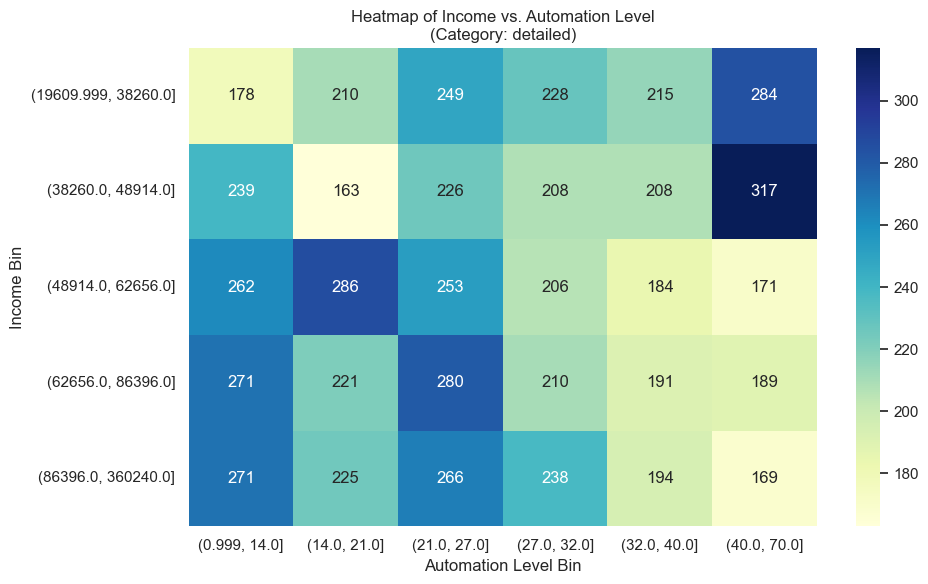

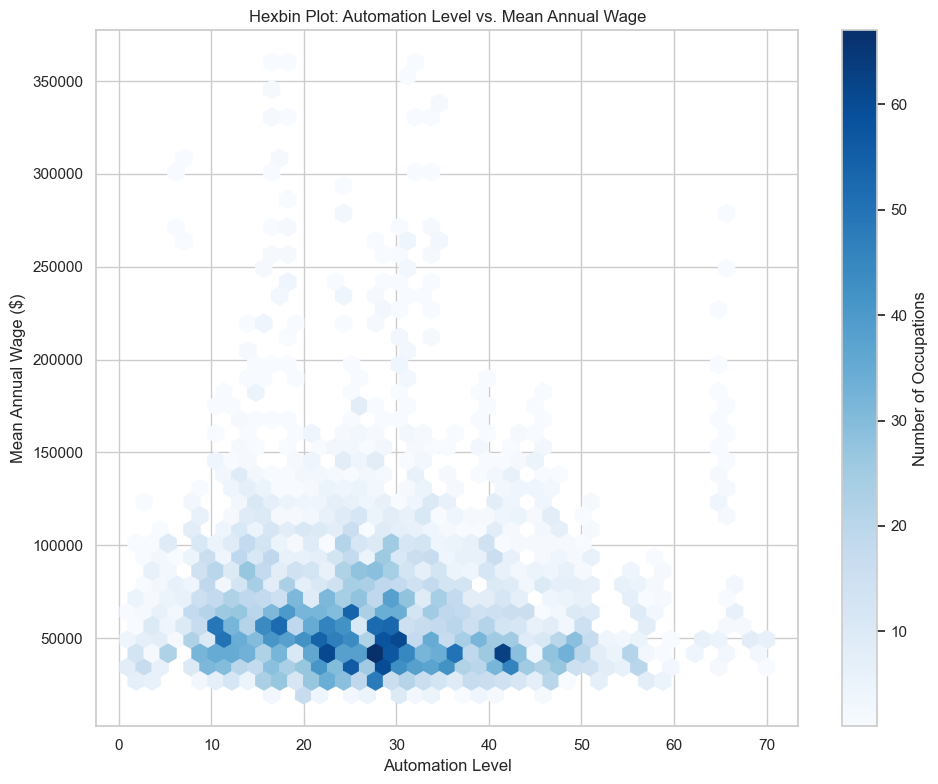

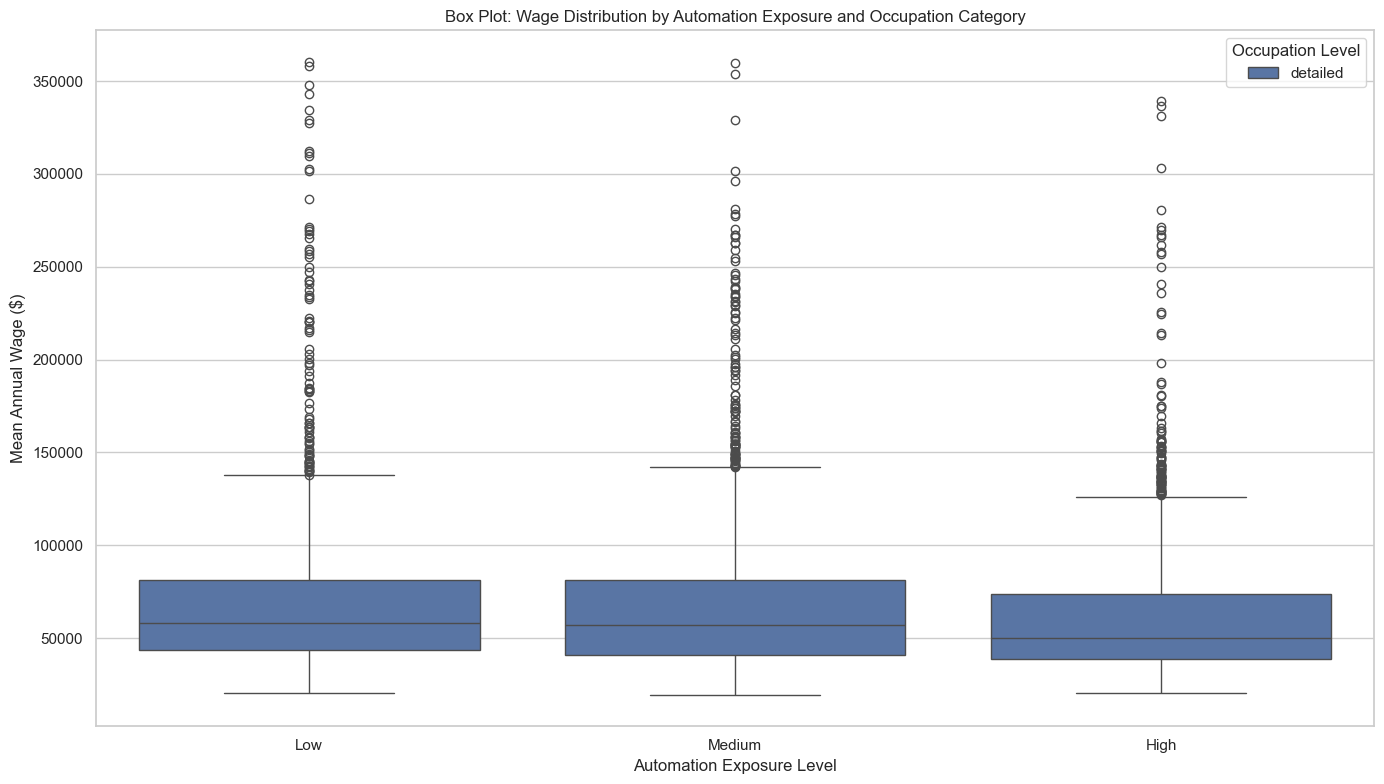

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Set plot style
sns.set(style="whitegrid")

# === Step 1: Load Data ===
file_path = "output/3_merge_OEWS/3_detailed_cleaned_for_regression.xlsx"
df = pd.read_excel(file_path)

# === Step 2: Rename columns for visualization ===
df = df.rename(columns={
    "a_mean": "Wage",
    "automation_score": "Automation",
    "o_group": "Category"  # e.g., 'detailed', 'broad', 'major'
})

# === Step 3: Convert types and drop NAs ===
df["Wage"] = pd.to_numeric(df["Wage"], errors="coerce")
df["Automation"] = pd.to_numeric(df["Automation"], errors="coerce")
df = df.dropna(subset=["Wage", "Automation", "Category"])

# === Step 4: Bin income and automation levels ===
df["Income Bin"] = pd.qcut(df["Wage"], q=5)
df["Automation Bin"] = pd.qcut(df["Automation"], q=6)

# === Plot 1: Heatmap for each Category group ===
categories = df["Category"].unique()

for category in categories:
    subset = df[df["Category"] == category]
    heatmap_data = pd.crosstab(subset["Income Bin"], subset["Automation Bin"])

    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt="d")
    plt.title(f"Heatmap of Income vs. Automation Level\n(Category: {category})")
    plt.xlabel("Automation Level Bin")
    plt.ylabel("Income Bin")
    plt.tight_layout()
    plt.show()

# === Plot 2: Hexbin plot of all jobs ===
plt.figure(figsize=(10, 8))
plt.hexbin(df["Automation"], df["Wage"], gridsize=40, cmap="Blues", mincnt=1)
plt.colorbar(label="Number of Occupations")
plt.xlabel("Automation Level")
plt.ylabel("Mean Annual Wage ($)")
plt.title("Hexbin Plot: Automation Level vs. Mean Annual Wage")
plt.tight_layout()
plt.show()

# === Plot 3: Boxplot of income by automation exposure and category ===
df["Exposure Level"] = pd.qcut(df["Automation"], q=3, labels=["Low", "Medium", "High"])

plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x="Exposure Level", y="Wage", hue="Category")
plt.title("Box Plot: Wage Distribution by Automation Exposure and Occupation Category")
plt.ylabel("Mean Annual Wage ($)")
plt.xlabel("Automation Exposure Level")
plt.legend(title="Occupation Level")
plt.tight_layout()
plt.show()

/var/folders/cj/742s04b178ld3v0xjpn8xzt80000gn/T/ipykernel_16725/729980785.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


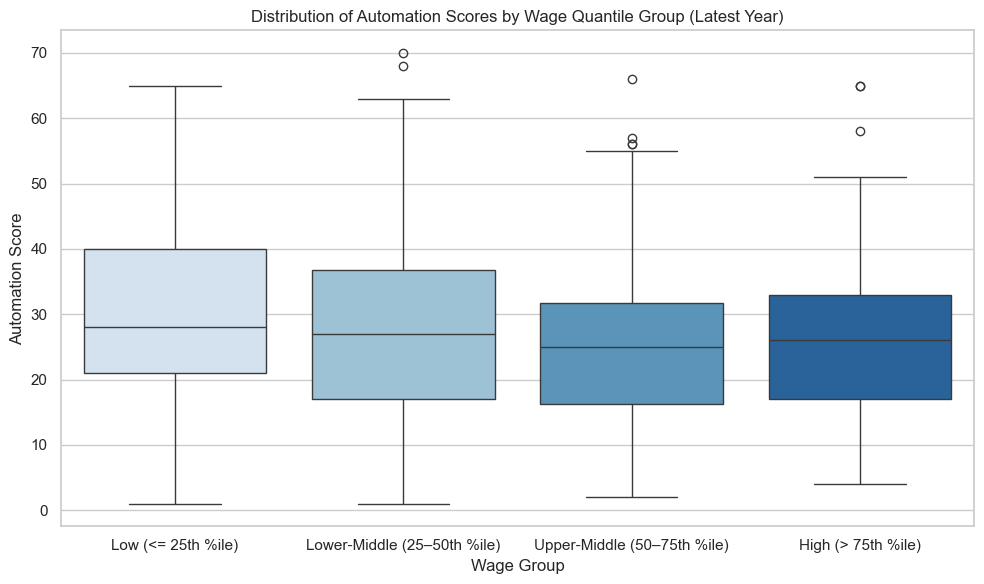


Automation Score Quantiles by Wage Group:

                             10th %ile  25th %ile  Median  75th %ile  \
Wage Group                                                             
High (> 75th %ile)                13.0      17.00    26.0      33.00   
Low (<= 25th %ile)                12.0      21.00    28.0      40.00   
Lower-Middle (25–50th %ile)       11.0      17.00    27.0      36.75   
Upper-Middle (50–75th %ile)       10.7      16.25    25.0      31.75   

                             90th %ile  
Wage Group                              
High (> 75th %ile)                42.2  
Low (<= 25th %ile)                47.0  
Lower-Middle (25–50th %ile)       46.3  
Upper-Middle (50–75th %ile)       42.0  


In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# === Step 1: Load data ===
df = pd.read_excel("output/3_merge_OEWS/3_detailed_cleaned_for_regression.xlsx")

# === Step 2: Clean and convert columns ===
df["Annual Earnings"] = pd.to_numeric(df["a_mean"], errors="coerce")
df["Automation Score"] = pd.to_numeric(df["automation_score"], errors="coerce")
df["Year"] = pd.to_numeric(df["year"], errors="coerce")

# === Step 3: Filter to latest year and drop NA values ===
latest_year = df["Year"].max()
df_latest = df[df["Year"] == latest_year].copy()
df_latest = df_latest.dropna(subset=["Annual Earnings", "Automation Score"])

# === Step 4: Create wage quantile groups ===
q25, q50, q75 = df_latest["Annual Earnings"].quantile([0.25, 0.5, 0.75])

def get_wage_group(val):
    if val <= q25:
        return "Low (<= 25th %ile)"
    elif val <= q50:
        return "Lower-Middle (25–50th %ile)"
    elif val <= q75:
        return "Upper-Middle (50–75th %ile)"
    else:
        return "High (> 75th %ile)"

df_latest["Wage Group"] = df_latest["Annual Earnings"].apply(get_wage_group)

# === Step 5: Create and save boxplot ===
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
order = ["Low (<= 25th %ile)", "Lower-Middle (25–50th %ile)", "Upper-Middle (50–75th %ile)", "High (> 75th %ile)"]
sns.boxplot(
    data=df_latest,
    x="Wage Group",
    y="Automation Score",
    order=order,
    palette="Blues"
)

plt.title("Distribution of Automation Scores by Wage Quantile Group (Latest Year)")
plt.xlabel("Wage Group")
plt.ylabel("Automation Score")
plt.tight_layout()

output_dir = "output/3_merge_OEWS"
os.makedirs(output_dir, exist_ok=True)
plot_path = f"{output_dir}/boxplot_automation_by_wage_group.png"
plt.savefig(plot_path)
plt.show()

# === Step 6: Create and print + save quantile summary table ===
quantile_summary = (
    df_latest.groupby("Wage Group")["Automation Score"]
    .quantile([0.1, 0.25, 0.5, 0.75, 0.9])
    .unstack(level=1)
    .rename(columns={
        0.1: "10th %ile",
        0.25: "25th %ile",
        0.5: "Median",
        0.75: "75th %ile",
        0.9: "90th %ile"
    })
)

print("\nAutomation Score Quantiles by Wage Group:\n")
print(quantile_summary.round(2))

# === Save the table as CSV ===
table_path = f"{output_dir}/automation_score_quantiles_by_wage_group.csv"
quantile_summary.to_csv(table_path)

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# === Step 1: Load the data ===
df = pd.read_excel("output/3_merge_OEWS/3_all_cleaned_for_regression.xlsx")

# === Step 2: Clean and convert relevant columns ===
df["Annual Earnings"] = pd.to_numeric(df["a_mean"], errors="coerce")
df["Automation Score"] = pd.to_numeric(df["automation_score"], errors="coerce")
df["Job Zone"] = pd.to_numeric(df["job zone"], errors="coerce")

# === Step 3: Filter for valid rows and only "broad" occupations ===
df_broad = df[(df["o_group"] == "broad") & df[["Annual Earnings", "Automation Score", "Job Zone"]].notna().all(axis=1)].copy()

# === Step 4: Set up output folder ===
output_dir = "output/3_merge_OEWS"
os.makedirs(output_dir, exist_ok=True)

# === Plot 1: Box Plot - Annual Earnings by Job Zone ===
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_broad,
    x="Job Zone",
    y="Annual Earnings",
    palette="Blues"
)
plt.title("Annual Earnings by Job Zone (Broad Occupations)")
plt.xlabel("Job Zone")
plt.ylabel("Annual Earnings ($)")
plt.tight_layout()
plt.savefig(f"{output_dir}/boxplot_earnings_by_job_zone_broad.png")
plt.close()

# === Plot 2: Scatter Plot - Automation Score vs. Annual Earnings by Job Zone ===
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_broad,
    x="Automation Score",
    y="Annual Earnings",
    hue="Job Zone",
    palette="viridis",
    alpha=0.7
)
plt.title("Automation Score vs. Annual Earnings by Job Zone (Broad Occupations)")
plt.xlabel("Automation Score")
plt.ylabel("Annual Earnings ($)")
plt.legend(title="Job Zone", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"{output_dir}/scatter_automation_vs_earnings_by_jobzone_broad.png")
plt.close()

/var/folders/cj/742s04b178ld3v0xjpn8xzt80000gn/T/ipykernel_16725/1135280960.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
